In [2]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import matplotlib.pyplot 
import Bio
#Neighbour Join Tree
import pandas as pd
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
import matplotlib.pyplot as plt
import Bio.Phylo as Phylo
import os
import Bio.Phylo as Phylo
import warnings

In [3]:
df_weekly_sum = pd.read_csv('dpgr_who_continets.csv')
print(df_weekly_sum)

      Variant                   Date       Location  Freq
0       Alpha  2019-12-30/2020-01-05         Africa     1
1       Alpha  2019-12-30/2020-01-05           Asia     8
2       Alpha  2019-12-30/2020-01-05         Europe   629
3       Alpha  2019-12-30/2020-01-05  North America     9
4       Alpha  2020-02-03/2020-02-09         Europe     1
...       ...                    ...            ...   ...
1563  Omicron  2022-05-30/2022-06-05           Asia   273
1564  Omicron  2022-05-30/2022-06-05         Europe  5815
1565  Omicron  2022-05-30/2022-06-05  North America  4399
1566  Omicron  2022-05-30/2022-06-05        Oceania   365
1567  Omicron  2022-05-30/2022-06-05  South America    67

[1568 rows x 4 columns]


In [4]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

#function to generate distance matrix based on quarter, year, and continent
# def create_distance_matrix(df,quarter_continent):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     distance_matrix = pd.DataFrame(index = clade_list)
#     distance_matrix[clade_list] = np.nan
#     #fill in distance matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 distance_matrix.loc[i,j] = 0
#             else:
#                 distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     return distance_matrix

#this distance matrix only selects clades thats within the clade list
def create_distance_matrix(df, quarter_continent, variant_choice_set):
    clade_list = set()
    for variant in df['Variant']:
        clades = variant.split(' vs ')
        clade_list.update(clades)
#         print(clade_list)

    
    clade_list = sorted(clade_list)
    clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
    distance_matrix.fillna(0, inplace=True)

    for i in clade_list:
        for j in clade_list:
            if i != j:
                variant_1 = f"{i} vs {j}"
                variant_2 = f"{j} vs {i}"
                slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
                slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
                slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
                distance_matrix.loc[i, j] = abs(slope)
                distance_matrix.loc[j, i] = abs(slope)

    return distance_matrix


# #function to generate difference matrix based on quarter, year, and continent
# def create_difference_matrix(df,quarter_continent):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     difference_matrix = pd.DataFrame(index = clade_list)
#     difference_matrix[clade_list] = np.nan
#     #fill in difference matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 difference_matrix.loc[i,j] = 0
#             else:
#                 difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     #if row_vs_col is a negative value, make it negative in difference matrix
#     for i,v in difference_matrix.iterrows():
#         for j in difference_matrix:
#             if i != j:
#                 if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
#                     difference_matrix.loc[i,j] *= -1
#     return difference_matrix

#Modifed the distance matrix , here the input is only the generated distance matrix
#function to generate difference matrix based on quarter, year, and continent
# def create_difference_matrix(distance_matrix):
# #     tmp = df['Variant'].str.split('vs', expand=True)
# #     clade_list = tmp[0].unique()
# #     difference_matrix = pd.DataFrame(index = clade_list)
# #     difference_matrix[clade_list] = np.nan
# #     #fill in difference matrix
# #     for i in clade_list:
# #         for j in clade_list:
# #             if i == j:
# #                 difference_matrix.loc[i,j] = 0
# #             else:
# #                 difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
# #                                                         quarter_continent].iloc[0] + 
# #                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                    quarter_continent].iloc[0])/2))
# #                 difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                         quarter_continent].iloc[0] + 
# #                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
# #                                                    quarter_continent].iloc[0])/2))
#     #if row_vs_col is a negative value, make it negative in difference matrix
# #     for i,v in difference_matrix.iterrows():
# #         for j in difference_matrix:
# #             if i != j:
# #                 if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
# #                     difference_matrix.loc[i,j] *= -1
# #     return difference_matrix

#     difference_matrix = distance_matrix.copy()

#     # Iterate over the rows and columns of the difference_matrix
#     for i, row in difference_matrix.iterrows():
#         for j in difference_matrix.columns:
#             if i != j:
#                 # Check if the row_vs_col value is negative
#                 if distance_matrix.loc[i, j] < 0:
#                     # Set values above the main diagonal to the negative value
#                     difference_matrix.loc[i, j] = -abs(difference_matrix.loc[i, j])
#                     print(difference_matrix)
#                 else:
#                     # Set values below the main diagonal to the positive value
#                     difference_matrix.loc[i, j] = abs(difference_matrix.loc[i, j])
                    
#         return difference_matrix

def create_difference_matrix(distance_matrix):
    difference_matrix = distance_matrix.copy()

    # Iterate over the rows and columns of the difference_matrix
    for i, row in difference_matrix.iterrows():
        for j in difference_matrix.columns:
            if i != j:
                # Check if the row_vs_col value is negative
                if distance_matrix.loc[i, j] < 0:
                    # Set values above the main diagonal to the negative value
                    difference_matrix.loc[i, j] = -abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = abs(difference_matrix.loc[i, j])
                else:
                    # Set values below the main diagonal to the positive value
                    difference_matrix.loc[i, j] = abs(difference_matrix.loc[i, j])
                    difference_matrix.loc[j, i] = -abs(difference_matrix.loc[i, j])

    return difference_matrix


#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
#     print(f"dataframe after time window:\n {dataframe.head()}")
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

### *Use the automation mine function to create the distance matrix in variant choice set for specific time window*

In [5]:
# This function finds the distance matrix among all the clades 

def automation_mine(country, dataset, start, end, variant_choice_set):
    
    df_weekly = dataset[dataset['Location'] == country]
    
#     # Set the option to display all rows
#     pd.set_option('display.max_rows', None)
#     print(df_weekly)
    
#     print(df_weekly.head())
    #print unique variants available in the target location
    print(f"Vaiants available at {country} : {df_weekly['Variant'].unique()}")
    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
    tmp.columns = ['0','1','2','3']

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
#     print(f"df_weekly :\n {df_weekly.head}")
#     print(f"df_weekly : \n {df_weekly.columns}")
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
    # df_sum.to_csv(country+"df_sum"+r'.csv')
#     print(f"df_sum :\n {df_sum}")
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(f" df_ : \n{df_}")
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
#     print(f"df_ :\n {df_}")
#     print(f"df_ :\n {df_.columns}")
    

    #Make the combinations of the variant choice set
    combinations = []

    # Append 'Omicron vs Delta'
    combination1 = ' vs '.join(variant_choice_set)
    combinations.append(combination1)

    # Append 'Delta vs Omicron'
    combination2 = ' vs '.join(sorted(list(variant_choice_set), reverse=True))
    combinations.append(combination2)
    

    #calculate slopes, have to disregard nans
    df_slopes = pd.DataFrame()
    cols = df_.columns.to_list()
#     print(f"df_ columns : {cols}")
    df_slopes['Variant'] = cols[3:]
#     print(f"df_slopes:\n {df_slopes}")
    slopes = []
    for i,v in enumerate(df_.iloc[:,3:]):
#         tmp = df_[~df_.iloc[:,i+3].isnull()] ##issue (it chooses columns using the index)
        tmp = df_[df_.loc[:, df_.columns.isin(combinations)].notnull().any(axis=1)] #it chooses the columns that are given in the variant_choice set
        tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
#         print(f"tmp :\n {tmp}")
        slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
#         slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp[v])) 
        #print(len(slopes))
#         print(df_slopes)
#     print(f"tmp :\n {tmp}")
#     print(f"Slopes: {slopes}")
    df_slopes['Slope'] = slopes
#     print(df_slopes)
    df_slopes = pd.DataFrame(df_slopes)   #changed
    
#     dist_mat = create_distance_matrix(df_slopes,'Slope')
#     # dist_mat.to_csv(country+"_dist_mat_WHO"+r'.csv')
#     print(f"distance matrix :\n {dist_mat}")

#     #define the file path
#     file_path = f'/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/{country + "_" + start + "_" + end + "_dist_mat_who_labels"}.csv'

    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
#     dist_mat.to_csv(file_path, index=True)
    print(f"Diatance matrix: \n {dist_mat}")
    
    dist_mat = create_distance_matrix(df_slopes, 'Slope', variant_choice_set)
    file_name = f"{country}_{start}_{end}_dist_mat.csv"
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, file_name)
    dist_mat.to_csv(file_path, index=True)
    if os.path.isfile(file_path):
        print(f"Distance matrix saved at: {file_path}")
    else:
        print("Error: Failed to save the distance matrix.")


#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_regression_plots/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)
    
#     dif_mat = create_difference_matrix(df_slopes,'Slope')
#     # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
#     # print(f"difference matrix :\n {dif_mat}")

#     #Plot distance matrix as clustermap
#     sns.set(rc = {'figure.figsize':(10, 20)}, font_scale = 1.8)

#     #create distance array from distance matrix
#     distance_array = ssd.squareform(dist_mat) 

#     #create linkage object
#     distance_linkage = hierarchy.linkage(distance_array)
#     print(distance_array.shape)
#     print(dist_mat.shape)

#     #display clustermap
#     g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
#                         cmap = 'coolwarm',vmin=-.023,vmax=0.023, cbar_pos=(0.971, 0.087, .03, 0.7))                     
#     # g.fig.set_size_inches(10, 10)
#     # plt.savefig(country+"_clustermap_WHO"+'.jpg', dpi = 300, bbox_inches='tight')
#     return g

## North America

In [6]:
# #automation function finds the diatance matrix
automation_mine('North America', df_weekly_sum, start = '2020-12', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})

Vaiants available at North America : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.000392
Beta   0.000392  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2020-12_2021-01_dist_mat.csv


In [7]:
# #automation function finds the diatance matrix
automation_mine('North America', df_weekly_sum, start = '2021-08', end = '2021-09', variant_choice_set= {'Beta', 'Delta'})

Vaiants available at North America : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-08', '2021-09']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.006185
Delta  0.006185  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2021-08_2021-09_dist_mat.csv


In [8]:
# #automation function finds the diatance matrix
automation_mine('North America', df_weekly_sum, start = '2022-03', end = '2022-05', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at North America : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2022-03', '2022-04', '2022-05']
Diatance matrix: 
            Delta  Omicron
Delta    0.00000  0.00801
Omicron  0.00801  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2022-03_2022-05_dist_mat.csv


In [9]:
alpha_beta_na = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2020-12_2021-01_dist_mat.csv',
    index_col=0)
alpha_beta_na

,Alpha,Beta
Alpha,0.000000,0.000392
Beta,0.000392,0.000000


In [10]:
beta_delta_na = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2021-08_2021-09_dist_mat.csv',
    index_col= 0)
beta_delta_na

,Beta,Delta
Beta,0.000000,0.006185
Delta,0.006185,0.000000


In [11]:
delta_omicron_na = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_2022-03_2022-05_dist_mat.csv',
    index_col=0)
delta_omicron_na

,Delta,Omicron
Delta,0.00000,0.00801
Omicron,0.00801,0.00000


### *Combine the distance matrices and plot the heatmap for getting the combined distance matrix for all the variants*

In [108]:
def heatmaps_from_combined_dist_map(clade_list, df1, df2, df3, location): #pass dataframe in a sorted order
    # create an empty dataframe
    clade_list = sorted(clade_list)
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    distance_matrix.fillna(0, inplace=True)
    
    # assign values to the empty dataframe
    distance_matrix.iloc[0:2, 0:2] = pd.DataFrame(df1)
    distance_matrix.iloc[1:3, 1:3] = pd.DataFrame(df2)
    distance_matrix.iloc[2:4, 2:4] = pd.DataFrame(df3)
    
    distance_matrix.iloc[0,2] = distance_matrix.iloc[0,1] + distance_matrix.iloc[1,2]
    distance_matrix.iloc[0,3] = distance_matrix.iloc[0,2] + distance_matrix.iloc[3,2]
    distance_matrix.iloc[1,3] = distance_matrix.iloc[1,2] + distance_matrix.iloc[2,3]
    distance_matrix.iloc[2,0] = distance_matrix.iloc[0,2] 
    distance_matrix.iloc[3,0] = distance_matrix.iloc[0,3] 
    distance_matrix.iloc[3,1] = distance_matrix.iloc[1,3] 
    
    # Set the index of the dataframe to the first column
    distance_matrix.set_index(distance_matrix.columns, inplace=True)
    print(f"Distance Matrix :\n {distance_matrix}")
    
    #export the combined distance matrix
    #export the distance matrix
    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

    
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_continent_combined_distance_matrix_for_who_labels.csv")
    print(f"Combined distance matrix saved at : {filename}")
    distance_matrix.to_csv(filename, index=False)

    
    dif_mat = create_difference_matrix(distance_matrix)
    # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
    print(f"difference matrix :\n {dif_mat}")
    
    #Plot distance matrix as clustermap
    sns.set(rc={'figure.figsize': (2, 2)}, font_scale=1.2)  # Adjust the figsize as per your preference

    #create distance array from distance matrix
    distance_array = ssd.squareform(distance_matrix) 

    #create linkage object
    distance_linkage = hierarchy.linkage(distance_array)
#     print(distance_array.shape)
#     print(dist_mat.shape)

    # # Display clustermap
    # g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
    #                cmap='coolwarm', vmin=-.023, vmax=0.023, cbar_pos=(0.971, 0.274, .05, 0.54 ),figsize=(4, 4))
    
    # Display clustermap with annotations
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
                           cmap='coolwarm', vmin=-0.023, vmax=0.023, cbar_pos=(0.969, 0.147, 0.04, 0.7),
                           annot=True, fmt='.3f', annot_kws={"size": 7}, figsize=(4.6, 4.6), dendrogram_ratio=0.102)
    
        # Adjust colorbar label size
        cax = g.cax
        cax.set_yticklabels(cax.get_yticklabels(), fontsize=7)

#***************************************************************************************************************************************
    #Put the labels compared in each cell as text
    # Get the x-axis and y-axis labels from the clustermap plot
    x_labels = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
    y_labels = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
    # Add annotated texts in the cells
    for i in range(dif_mat.shape[0]):
        for j in range(dif_mat.shape[1]):
            text = f"{x_labels[i]} Vs. {y_labels[j]}"
            # value = f"{dif_mat.iloc[i, j]:.3f}"
            text_x = g.ax_heatmap.get_xticks()[j]
            text_y = g.ax_heatmap.get_yticks()[i]
            g.ax_heatmap.text(text_x, text_y + 0.2, text, ha='center', va='center', fontsize=5.5, color='black')
            
#***************************************************************************************************************************************
    
    g.fig.suptitle(f'Clustermap of Variant of Concerns(WHO labels) \nLocation: {location}', fontsize = 8.5, y = 1.05)

    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/combined_heatmaps_continents_WHO labels/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, location + "_Omicron_vs_delta_combined_heatmaps_continents.png")
    g.savefig(filename, dpi=300, bbox_inches="tight")
    return g

    
    '''
        This portion of code plots the step plot of progressive fitness growth 
        of the variants
    '''
    #*******************************************************************************************************************
#     #export the combined distance matrix
#     #export the distance matrix
#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_combined_distance_matrix_for_who_labels.csv")
#     distance_matrix.to_csv(filename, index=False)
    
#     # Create a step plot
#     plt.figure(figsize=(3, 3))  # Set figure size to 3 by 3
#     plt.step(distance_matrix.index, distance_matrix.values[0], linewidth=1.5, color='red')

#     # Add labels and title
# #     plt.xlabel('Variants', fontsize=12)
#     plt.ylabel('Fitness Value', fontsize=12)
#     plt.title(f'Progressive fitness growth of Covid Variants\n Location: {location}', fontsize=12)

#     # Set the background color to white
#     plt.gca().set_facecolor('white')

#     # Add axis lines
#     plt.axhline(0, color='black', linewidth=0.5)
#     plt.axvline(-0.1, color='black', linewidth=0.5)
    
#     # Rotate x-axis labels
# #     plt.xticks(range(len(distance_matrix.index)), distance_matrix.index, rotation=90, fontsize=8)  # Adjust fontsize as needed
#     plt.xticks([])  # Remove x-axis tick labels
#     plt.yticks()

#     # Display the labels on the graph
#     categories = ['alpha', 'beta', 'delta', 'omicron']
#     x = range(len(categories))
#     values = distance_matrix.values[0][0:5]
#     print(values)
#     for i in range(len(categories)):
#         plt.text(x[i], values[i], f'{categories[i]}', ha='left', va='bottom')

# #     # Rotate x-axis labels
# #     plt.xticks(rotation=90)
# #     plt.yticks()

#     # Specify the directory path
#     directory = "/scr/mjpantho/Pantho_differential_fitness/figures_for_step_plot/"

#     # Create the directory if it doesn't exist
#     if not os.path.exists(directory):
#         os.makedirs(directory)

#     # Save the figure to the specified directory with DPI set to 300
#     filename = os.path.join(directory, location + "_variant_step_plot.png")
#     plt.savefig(filename, dpi=300, bbox_inches="tight")
    
#     # Show the plot
#     plt.show()
    #*********************************************************************************************************************

Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.000392  0.006577  0.014587
Beta     0.000392  0.000000  0.006185  0.014195
Delta    0.006577  0.006185  0.000000  0.008010
Omicron  0.014587  0.014195  0.008010  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/North America_continent_combined_distance_matrix_for_who_labels.csv
difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.000392 -0.006577 -0.014587
Beta     0.000392  0.000000 -0.006185 -0.014195
Delta    0.006577  0.006185  0.000000 -0.008010
Omicron  0.014587  0.014195  0.008010  0.000000


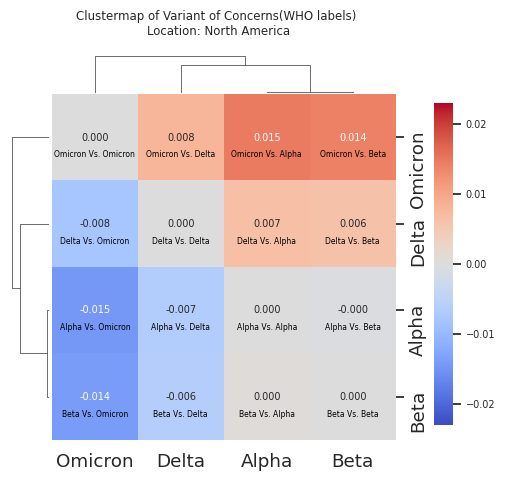

In [109]:
clustermap_obj_na = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_na,
                                                    beta_delta_na,
                                                    delta_omicron_na,
                                                    'North America')
combined_distance_matrix_na = pd.DataFrame(clustermap_obj_na.data)

## Europe 

In [110]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Europe'])

In [111]:
# #automation function finds the diatance matrix
automation_mine('Europe', df_weekly_sum, start = '2020-11', end = '2020-12', variant_choice_set= {'Alpha', 'Beta'})

Vaiants available at Europe : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-11', '2020-12']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.012519
Beta   0.012519  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2020-11_2020-12_dist_mat.csv


In [112]:
# #automation function finds the diatance matrix
automation_mine('Europe', df_weekly_sum, start = '2021-04', end = '2021-05', variant_choice_set= {'Beta', 'Delta'})

Vaiants available at Europe : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-04', '2021-05']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.031843
Delta  0.031843  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2021-04_2021-05_dist_mat.csv


In [113]:
# #automation function finds the diatance matrix
automation_mine('Europe', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Europe : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.072727
Omicron  0.072727  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2021-11_2021-12_dist_mat.csv


In [114]:
alpha_beta_eu = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2020-11_2020-12_dist_mat.csv',
    index_col=0)
alpha_beta_eu

,Alpha,Beta
Alpha,0.000000,0.012519
Beta,0.012519,0.000000


In [115]:
beta_delta_eu = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2021-04_2021-05_dist_mat.csv',
    index_col= 0)
beta_delta_eu

,Beta,Delta
Beta,0.000000,0.031843
Delta,0.031843,0.000000


In [116]:
delta_omicron_eu = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_2021-11_2021-12_dist_mat.csv',
    index_col=0)
delta_omicron_eu

,Delta,Omicron
Delta,0.000000,0.072727
Omicron,0.072727,0.000000


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.012519  0.044362  0.117089
Beta     0.012519  0.000000  0.031843  0.104570
Delta    0.044362  0.031843  0.000000  0.072727
Omicron  0.117089  0.104570  0.072727  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Europe_continent_combined_distance_matrix_for_who_labels.csv
difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.012519 -0.044362 -0.117089
Beta     0.012519  0.000000 -0.031843 -0.104570
Delta    0.044362  0.031843  0.000000 -0.072727
Omicron  0.117089  0.104570  0.072727  0.000000


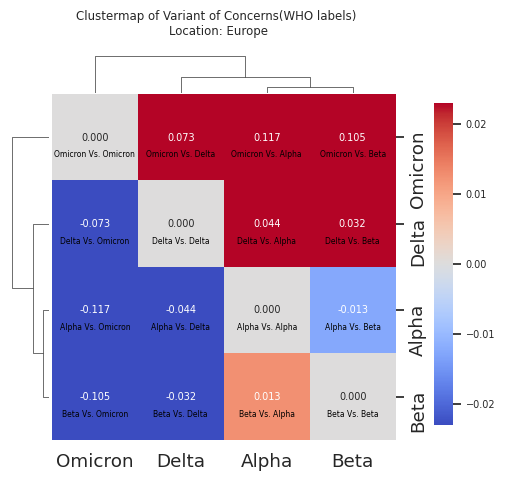

In [117]:
clustermap_obj_eu = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_eu,
                                                    beta_delta_eu,
                                                    delta_omicron_eu,
                                                    'Europe')
combined_distance_matrix_eu = pd.DataFrame(clustermap_obj_eu.data)

## Asia

In [118]:
# # #automation function finds the diatance matrix
# automation_mine('Asia', df_weekly_sum, start = '2020-11', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})

In [119]:
# #automation function finds the diatance matrix
automation_mine('Asia', df_weekly_sum, start = '2021-02', end = '2021-04', variant_choice_set= {'Beta', 'Delta'})

Vaiants available at Asia : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-02', '2021-03', '2021-04']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.008729
Delta  0.008729  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2021-02_2021-04_dist_mat.csv


In [120]:
# #automation function finds the diatance matrix
automation_mine('Asia', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Asia : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.044816
Omicron  0.044816  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2021-11_2021-12_dist_mat.csv


In [121]:
alpha_beta_asia = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2020-11_2021-01_dist_mat.csv',
    index_col=0)
alpha_beta_asia

,Alpha,Beta
Alpha,0.000000,0.004142
Beta,0.004142,0.000000


In [122]:
beta_delta_asia = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2021-02_2021-04_dist_mat.csv',
    index_col= 0)
beta_delta_asia

,Beta,Delta
Beta,0.000000,0.008729
Delta,0.008729,0.000000


In [123]:
delta_omicron_asia = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_2021-11_2021-12_dist_mat.csv',
    index_col=0)
delta_omicron_asia

,Delta,Omicron
Delta,0.000000,0.044816
Omicron,0.044816,0.000000


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.004142  0.012872  0.057688
Beta     0.004142  0.000000  0.008729  0.053545
Delta    0.012872  0.008729  0.000000  0.044816
Omicron  0.057688  0.053545  0.044816  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Asia_continent_combined_distance_matrix_for_who_labels.csv
difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.004142 -0.012872 -0.057688
Beta     0.004142  0.000000 -0.008729 -0.053545
Delta    0.012872  0.008729  0.000000 -0.044816
Omicron  0.057688  0.053545  0.044816  0.000000


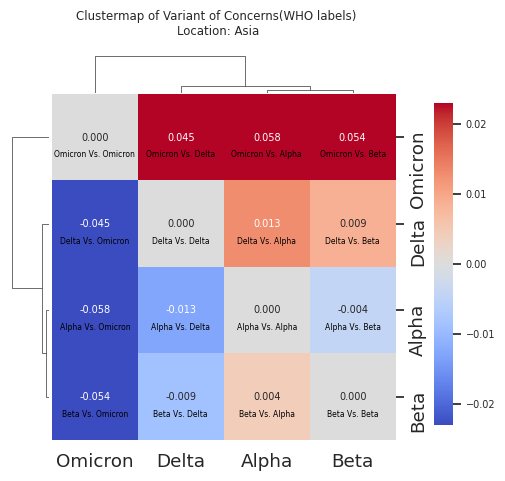

In [124]:
clustermap_obj_asia = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_asia,
                                                    beta_delta_asia,
                                                    delta_omicron_asia,
                                                    'Asia')
combined_distance_matrix_asia = pd.DataFrame(clustermap_obj_asia.data)

## Africa

In [125]:
# # pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Africa'])

In [126]:
# #automation function finds the diatance matrix
automation_mine('Africa', df_weekly_sum, start = '2020-11', end = '2021-01', variant_choice_set= {'Alpha', 'Beta'})

Vaiants available at Africa : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2020-11', '2020-12', '2021-01']
Diatance matrix: 
           Alpha      Beta
Alpha  0.000000  0.027493
Beta   0.027493  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2020-11_2021-01_dist_mat.csv


In [127]:
# #automation function finds the diatance matrix
automation_mine('Africa', df_weekly_sum, start = '2021-05', end = '2021-06', variant_choice_set= {'Beta', 'Delta'})

Vaiants available at Africa : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-05', '2021-06']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.021367
Delta  0.021367  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2021-05_2021-06_dist_mat.csv


In [128]:
# #automation function finds the diatance matrix
automation_mine('Africa', df_weekly_sum, start = '2021-11', end = '2021-11', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Africa : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.051399
Omicron  0.051399  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2021-11_2021-11_dist_mat.csv


In [129]:
alpha_beta_af = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2020-11_2021-01_dist_mat.csv',
    index_col=0)
alpha_beta_af

,Alpha,Beta
Alpha,0.000000,0.027493
Beta,0.027493,0.000000


In [130]:
beta_delta_af = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2021-05_2021-06_dist_mat.csv',
    index_col= 0)
beta_delta_af

,Beta,Delta
Beta,0.000000,0.021367
Delta,0.021367,0.000000


In [131]:
delta_omicron_af = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_2021-11_2021-11_dist_mat.csv',
    index_col=0)
delta_omicron_af

,Delta,Omicron
Delta,0.000000,0.051399
Omicron,0.051399,0.000000


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.027493  0.048860  0.100258
Beta     0.027493  0.000000  0.021367  0.072766
Delta    0.048860  0.021367  0.000000  0.051399
Omicron  0.100258  0.072766  0.051399  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Africa_continent_combined_distance_matrix_for_who_labels.csv
difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.027493 -0.048860 -0.100258
Beta     0.027493  0.000000 -0.021367 -0.072766
Delta    0.048860  0.021367  0.000000 -0.051399
Omicron  0.100258  0.072766  0.051399  0.000000


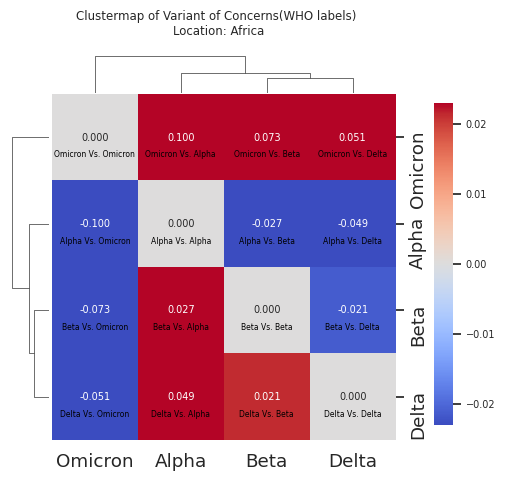

In [132]:
clustermap_obj_af = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_af,
                                                    beta_delta_af,
                                                    delta_omicron_af,
                                                    'Africa')
combined_distance_matrix_af = pd.DataFrame(clustermap_obj_af.data)

### Oceania

In [133]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'Oceania'])

In [134]:
# #automation function finds the diatance matrix
automation_mine('Oceania', df_weekly_sum, start = '2021-01', end = '2021-02', variant_choice_set= {'Alpha', 'Beta'})

Vaiants available at Oceania : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-01', '2021-02']
Diatance matrix: 
          Alpha     Beta
Alpha  0.00000  0.00755
Beta   0.00755  0.00000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-01_2021-02_dist_mat.csv


In [135]:
# #automation function finds the diatance matrix
automation_mine('Oceania', df_weekly_sum, start = '2021-06', end = '2021-07', variant_choice_set= {'Beta', 'Delta'})

Vaiants available at Oceania : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-06', '2021-07']
Diatance matrix: 
            Beta     Delta
Beta   0.000000  0.027171
Delta  0.027171  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-06_2021-07_dist_mat.csv


In [136]:
# #automation function finds the diatance matrix
automation_mine('Oceania', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Delta', 'Omicron'})

Vaiants available at Oceania : ['Alpha' 'Beta' 'Delta' 'Gamma' 'Omicron']
['2021-11', '2021-12']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.076072
Omicron  0.076072  0.000000
Distance matrix saved at: /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-11_2021-12_dist_mat.csv


In [137]:
alpha_beta_oc = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-01_2021-02_dist_mat.csv',
    index_col=0)
alpha_beta_oc

,Alpha,Beta
Alpha,0.00000,0.00755
Beta,0.00755,0.00000


In [138]:
beta_delta_oc = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-06_2021-07_dist_mat.csv',
    index_col= 0)
beta_delta_oc

,Beta,Delta
Beta,0.000000,0.027171
Delta,0.027171,0.000000


In [139]:
delta_omicron_oc = pd.read_csv(
    '/scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_2021-11_2021-12_dist_mat.csv',
    index_col=0)
delta_omicron_oc

,Delta,Omicron
Delta,0.000000,0.076072
Omicron,0.076072,0.000000


Distance Matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000  0.007550  0.034721  0.110792
Beta     0.007550  0.000000  0.027171  0.103243
Delta    0.034721  0.027171  0.000000  0.076072
Omicron  0.110792  0.103243  0.076072  0.000000
Combined distance matrix saved at : /scr/mjpantho/Pantho_differential_fitness/distance_matrix_for_step_plot/Oceania_continent_combined_distance_matrix_for_who_labels.csv
difference matrix :
             Alpha      Beta     Delta   Omicron
Alpha    0.000000 -0.007550 -0.034721 -0.110792
Beta     0.007550  0.000000 -0.027171 -0.103243
Delta    0.034721  0.027171  0.000000 -0.076072
Omicron  0.110792  0.103243  0.076072  0.000000


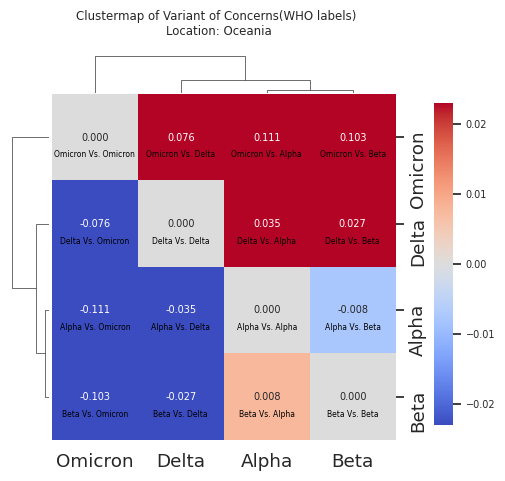

In [140]:
clustermap_obj_oc = heatmaps_from_combined_dist_map(['Alpha', 'Beta', 'Omicron', 'Delta'],
                                                    alpha_beta_oc,
                                                    beta_delta_oc,
                                                    delta_omicron_oc,
                                                    'Oceania')
combined_distance_matrix_oc = pd.DataFrame(clustermap_obj_oc.data)

## South America

In [141]:
# pd.set_option('display.max_rows', None)
# print(df_weekly_sum[df_weekly_sum['Location'] == 'South America'])

In [142]:
# #automation function finds the diatance matrix
# automation_mine('South America', df_weekly_sum, start = '2021-01', end = '2021-02', variant_choice_set= {'Alpha', 'Beta'})